In [71]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint

# Vídeo da apresentação: (https://drive.google.com/file/d/1x_50rLzKKt4SXuTkSdzJCh22aBx2zEEX/view?usp=sharing) 

## Declaração do Problema

A Transferência de Estilo Neural (NST) combina duas imagens: uma **imagem de "conteúdo" (C)** e uma **imagem de "estilo" (S)**, para criar uma **imagem "gerada" (G)**. A imagem gerada G combina o "conteúdo" da imagem C com o "estilo" da imagem S.

## Transferência de aprendizagem


A Transferência de Estilo Neural (NST) usa uma rede convolucional previamente treinada e se baseia nela. A ideia de usar uma rede treinada em uma tarefa diferente e aplicá-la a uma nova tarefa é chamada de aprendizagem por transferência.

Será usado a rede VGG de mesmo nome do [artigo original do NST](https://arxiv.org/abs/1508.06576) publicado pelo Visual Geometry Group da Universidade de Oxford em 2014. Especificamente a VGG- 19, uma versão de 19 camadas da rede VGG. Este modelo já foi treinado no grande banco de dados ImageNet e aprendeu a reconhecer uma variedade de recursos de baixo nível (nas camadas mais superficiais) e recursos de alto nível (nas camadas mais profundas).

**Explicação**:

1. **Definir a Semente Aleatória**:
   - `tf.random.set_seed(272)` define uma semente aleatória para que o processo seja reprodutível. Isso ajuda a garantir que os resultados permaneçam consistentes em execuções diferentes.

2. **PrettyPrinter**:
   - `pprint.PrettyPrinter` é uma ferramenta usada para imprimir objetos de forma estruturada e fácil de ler.

3. **Tamanho da Imagem**:
   - `img_size = 400` define o tamanho das imagens que serão processadas pelo modelo.

4. **Carregar o Modelo VGG19**:
   - `tf.keras.applications.VGG19` carrega a arquitetura do modelo VGG19.
   - **`include_top=False`**: Exclui as camadas de classificação para trabalhar apenas com as camadas convolucionais.
   - **`input_shape=(img_size, img_size, 3)`**: Define a forma das imagens de entrada, com largura e altura de 400 pixels e 3 canais (RGB).
   - **`weights='imagenet'`**: Carrega pesos pré-treinados da ImageNet.

5. **Modelo Não-Treinável**:
   - `vgg.trainable = False` torna o modelo não treinável, impedindo que seus pesos sejam atualizados durante o processo de otimização.

In [72]:
# Define uma semente aleatória para garantir a reprodutibilidade
tf.random.set_seed(272)

# Cria uma instância de PrettyPrinter com indentação de 4 espaços
pp = pprint.PrettyPrinter(indent=4)

# Define o tamanho das imagens usadas no modelo
img_size = 400

# Carrega o modelo VGG19 com pesos pré-treinados
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

# Configura o modelo para não ser treinável, ou seja, seus pesos não serão atualizados durante o treinamento
vgg.trainable = False

## Transferência de Estilo Neural (NST)

Vamos construir o algoritmo Neural Style Transfer (NST) em três etapas:

- Primeiro a função de custo de conteúdo $J_{content}(C,G)$
- Segundo a função de custo de estilo $J_{style}(S,G)$
- E por fim juntaremos tudo para obter $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$

Imagem conteudo (C)


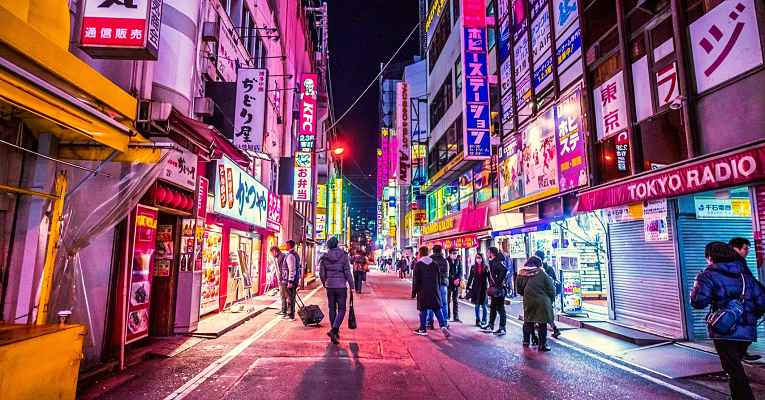

In [73]:
content_image = Image.open(r"C:\Users\arthu\Downloads\tokyo.jpg")
print("Imagem conteudo (C)")
content_image

**Explicação**:

1. **Obter Ativações**:
   - **`a_C` e `a_G`** são as ativações da camada de conteúdo para a imagem de referência e a imagem gerada, respectivamente.

2. **Recuperar Dimensões**:
   - As dimensões do tensor `a_G` (lote `m`, altura `n_H`, largura `n_W` e canais `n_C`) são obtidas para redimensionar as ativações.

3. **Redimensionar Ativações**:
   - As ativações `a_C` e `a_G` são redimensionadas para uma matriz 2D com forma `(m, n_H * n_W, n_C)`, tornando mais fácil comparar as ativações.

4. **Calcular Custo de Conteúdo**:
   - O custo de conteúdo `J_content` é calculado como a soma dos quadrados das diferenças entre `a_C_unrolled` e `a_G_unrolled`.
   - A fórmula também inclui uma normalização pelo produto `4.0 * n_H * n_W * n_C`.

5. **Retornar o Custo**:
   - A função retorna `J_content`, que é o valor escalar que representa o custo de conteúdo entre a imagem de referência e a imagem gerada.

In [74]:
def compute_content_cost(content_output, generated_output):
    # Obtém as ativações da última camada para a imagem de conteúdo e a imagem gerada
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Recupera as dimensões de a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Redimensiona 'a_C' e 'a_G' para que tenham dimensões (m, n_H * n_W, n_C)
    a_C_unrolled = tf.reshape(a_C, [m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, [m, n_H * n_W, n_C])
    
    # Calcula o custo de conteúdo usando a soma dos quadrados das diferenças
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4.0 * n_H * n_W * n_C)
    
    return J_content

Imagem estilo (C)


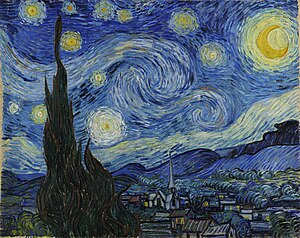

In [75]:
example = Image.open(r"C:\Users\arthu\Downloads\Van_Gogh_-_Starry_Night.jpg")
print("Imagem estilo (C)")
example

**Explicação**:

- **Objetivo da Função**:
  - A função `gram_matrix` calcula a matriz de Gram de um tensor `A`. A matriz de Gram é usada para representar as correlações entre diferentes filtros de uma camada convolucional, o que ajuda a capturar o estilo de uma imagem.

- **Como a Função Funciona**:
  - **Produto Interno**: A matriz de Gram é calculada como o produto interno de `A` com sua transposta usando `tf.matmul`.
  - `tf.matmul(A, tf.transpose(A))` calcula a matriz de Gram de `A`.

- **Retorno**:
  - A função retorna a matriz de Gram, `GA`, que representa as correlações entre diferentes filtros.

In [76]:
def gram_matrix(A):
    # Calcula a matriz de Gram como o produto da matriz A com sua transposta
    GA = tf.matmul(A, tf.transpose(A))
    
    # Retorna a matriz de Gram resultante
    return GA

**Explicação**:

1. **Obter Dimensões**:
   - As dimensões do tensor `a_G` (tamanho do lote `m`, altura `n_H`, largura `n_W` e canais `n_C`) são obtidas para redimensionar as ativações.

2. **Redimensionar Ativações**:
   - As ativações `a_S` e `a_G` são redimensionadas para uma matriz 2D de forma `(n_C, n_H * n_W)`, para calcular a matriz de Gram.

3. **Calcular Matrizes de Gram**:
   - `GS` e `GG` representam as matrizes de Gram calculadas para `a_S` e `a_G`, respectivamente, usando a função `gram_matrix`.

4. **Calcular Custo de Estilo**:
   - `J_style_layer` é calculado como a soma dos quadrados das diferenças entre as matrizes de Gram de `GS` e `GG`.
   - A fórmula também inclui uma normalização pelo produto de `n_C**2` e `(n_H * n_W)**2`.

5. **Retornar o Custo**:
   - A função retorna `J_style_layer`, que é o valor escalar que representa o custo de estilo para a camada oculta específica entre a imagem de estilo e a imagem gerada.

In [77]:
def compute_layer_style_cost(a_S, a_G):
    # Obtém as dimensões de a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Redimensiona os tensores de (1, n_H, n_W, n_C) para (n_C, n_H * n_W)
    a_S = tf.reshape(a_S, shape=[n_H * n_W, n_C])
    a_S = tf.transpose(a_S)
    a_G = tf.reshape(a_G, shape=[n_H * n_W, n_C])
    a_G = tf.transpose(a_G)

    # Calcula as matrizes de Gram para as imagens S e G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Calcula a perda de estilo
    J_style_layer = tf.reduce_sum(tf.square(GS - GG)) / (4.0 * n_C**2 * (n_H * n_W)**2)
    
    return J_style_layer


#### Pesos de estilo

* Até agora capturamos o estilo de apenas uma camada.
* Podemos obter melhores resultados se "mesclarmos" custos de estilo de várias camadas diferentes.
* Cada camada receberá pesos ($\lambda^{[l]}$) que refletem o quanto cada camada contribuirá para o estilo.
* Por padrão, atribuimos peso igual a cada camada e os pesos somam 1. ($\sum_{l}^L\lambda^{[l]} = 1$)

Listando os nomes das camadas:

In [78]:
for layer in vgg.layers:
    print(layer.name)

input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### `vgg.get_layer('block5_conv4').output`

- A camada `block5_conv4` é usada para calcular o custo de conteúdo porque captura informações detalhadas da imagem, mantendo o contexto global. Ela é a última camada convolucional da VGG19 antes das camadas totalmente conectadas, capturando assim as características mais significativas e detalhadas do conteúdo da imagem.
- Em transferências de estilo neural, camadas mais profundas como `block5_conv4` são melhores para capturar o conteúdo geral da imagem, pois contêm informações mais avançadas sobre a estrutura da imagem.

### `STYLE_LAYERS`

- A lista `STYLE_LAYERS` contém camadas selecionadas para calcular o custo de estilo.
- Cada camada é emparelhada com um coeficiente que indica seu peso relativo ao calcular o custo de estilo.

A razão para escolher apenas as primeiras camadas convolucionais de cada bloco (`conv1`) é que elas tendem a fornecer uma boa combinação de granularidade e eficiência no cálculo de características de estilo:

### Motivos para escolher `conv1`:
1. **Eficiência Computacional**: Escolher `conv1` de cada bloco reduz o número de operações necessárias para calcular o estilo, tornando o processo mais eficiente em termos computacionais.

2. **Características Significativas**: Cada bloco convolucional na VGG19 tem múltiplas camadas, mas o primeiro `conv1` de cada bloco captura características significativas de uma imagem com diferentes níveis de abstração.
   - **Bloco 1**: Captura bordas e texturas básicas.
   - **Bloco 2**: Captura padrões de texturas mais detalhados.
   - **Bloco 3**: Captura padrões mais complexos.
   - **Bloco 4 e 5**: Capturam padrões abstratos de alto nível.

3. **Evitar Redundância**: Usar apenas `conv1` de cada bloco evita a redundância de características similares que são capturadas em camadas subsequentes dentro do mesmo bloco.

4. **Captura de Estilos**: Cada `conv1` oferece uma visão única do estilo, com uma mistura de detalhes básicos e abstratos.
   - As camadas iniciais de cada bloco são responsáveis por capturar diferentes aspectos do estilo de uma imagem, tornando-as ideais para a transferência de estilo neural.

### Considerações:
- Usar outras camadas como `conv2` ou `conv3` poderia fornecer mais informações sobre o estilo, mas aumentaria o custo computacional, além de potencialmente introduzir redundância.
- Portanto, escolher `conv1` de cada bloco fornece uma boa abordagem prática para capturar o estilo com eficiência.

In [79]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [80]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

**Explicação**:

1. **Inicializar o Custo Total de Estilo**:
   - `J_style` é inicializado como zero para armazenar o custo total de estilo.

2. **Obter Ativações de Estilo**:
   - `a_S` contém as ativações das camadas de estilo para a imagem de estilo, excluindo a última camada (camada de conteúdo).
   - `a_G` contém as ativações das mesmas camadas para a imagem gerada.

3. **Iterar Sobre as Camadas de Estilo**:
   - Para cada camada listada em `STYLE_LAYERS`, `compute_layer_style_cost` é chamado para calcular o custo de estilo da camada atual.
   - `weight[1]` é o peso da camada na lista `STYLE_LAYERS`.
   - `J_style_layer` é multiplicado pelo peso e adicionado ao custo total de estilo `J_style`.

4. **Retornar o Custo Total de Estilo**:
   - A função retorna `J_style`, que é o custo total de estilo calculado a partir das várias camadas especificadas.

Este custo de estilo é usado para orientar a otimização da imagem gerada para se assemelhar ao estilo da imagem de referência.

In [81]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    # Inicializa o custo total de estilo
    J_style = 0

    # Define a_S como as ativações das camadas de estilo para a imagem de estilo
    a_S = style_image_output[:-1]

    # Define a_G como as ativações das camadas de estilo para a imagem gerada
    a_G = generated_image_output[:-1]

    # Itera através de cada camada e seu peso correspondente
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Calcula o custo de estilo para a camada atual
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Adiciona weight[1] * J_style_layer ao custo total de estilo
        J_style += weight[1] * J_style_layer

    return J_style

Como você escolhe os coeficientes para cada camada? As camadas mais profundas capturam conceitos de nível superior e os recursos nas camadas mais profundas são menos localizados na imagem em relação uns aos outros. Portanto, se você deseja que a imagem gerada siga suavemente o estilo da imagem, tente escolher pesos maiores para camadas mais profundas e pesos menores para as primeiras camadas. Por outro lado, se você deseja que a imagem gerada siga fortemente o estilo da imagem, tente escolher pesos menores para camadas mais profundas e pesos maiores para as primeiras camadas.



**Explicação**:

1. **Função Decorada `@tf.function`**:
   - `@tf.function` transforma a função em um gráfico computacional do TensorFlow, melhorando o desempenho.

2. **Parâmetros de Entrada**:
   - **`J_content`**: O custo de conteúdo, que mede a diferença de conteúdo entre a imagem gerada e a imagem de conteúdo.
   - **`J_style`**: O custo de estilo, que mede a diferença de estilo entre a imagem gerada e a imagem de estilo.
   - **`alpha`**: Um hiperparâmetro que determina a importância do custo de conteúdo.
   - **`beta`**: Um hiperparâmetro que determina a importância do custo de estilo.

3. **Calcular o Custo Total**:
   - `J` é calculado como a soma ponderada de `J_content` e `J_style`.
   - `alpha * J_content` adiciona o custo de conteúdo ponderado ao custo total.
   - `beta * J_style` adiciona o custo de estilo ponderado ao custo total.

4. **Retornar o Custo Total**:
   - A função retorna `J`, que é o custo total calculado.

In [82]:
@tf.function()
def total_cost(J_content, J_style, alpha=10, beta=40):
    
    # Calcula o custo total como uma combinação ponderada do custo de conteúdo e do custo de estilo
    J = alpha * J_content + beta * J_style
    
    return J


**Converter para Numpy e TensorFlow**:
   - A imagem é convertida para um array NumPy (`np.array`), em seguida, para um tensor TensorFlow (`tf.constant`).
   - Ela é redimensionada usando `np.reshape` para adicionar uma dimensão no início, tornando-a `(1, height, width, channels)`. Essa dimensão adicional é necessária para indicar que é um lote de imagens, mesmo que haja apenas uma.



(1, 400, 400, 3)


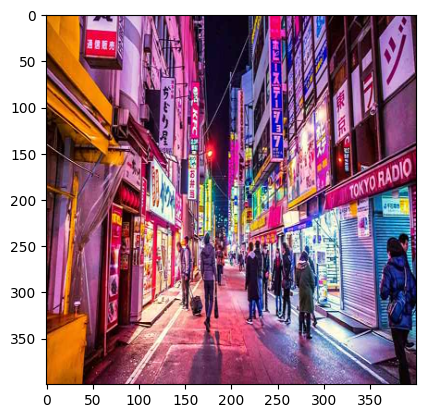

In [83]:
content_image = np.array(Image.open(r"C:\Users\arthu\Downloads\tokyo.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

O mesmo processo é repetido para a imagem de estilo, convertendo-as em tensores TensorFlow e redimensionando-as para o formato correto.

(1, 400, 400, 3)


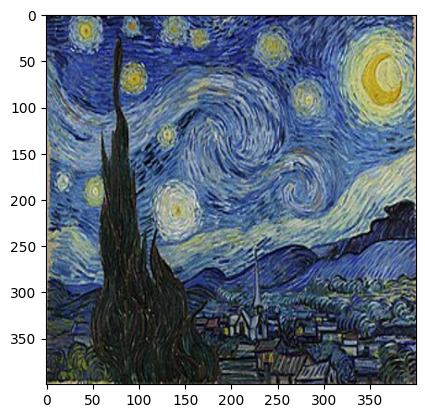

In [84]:
style_image =  np.array(Image.open(r"C:\Users\arthu\Downloads\Van_Gogh_-_Starry_Night.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

1. **Inicializa a Imagem Gerada**:
   - A `generated_image` é inicializada como uma cópia do tensor `content_image`, mas convertida para o tipo `tf.float32`.
   - `tf.image.convert_image_dtype` converte a imagem de entrada para um intervalo de valores apropriado para processamento.

2. **Adicionar Ruído à Imagem Gerada**:
   - O ruído é adicionado à `generated_image` para iniciar a otimização com uma imagem não idêntica à `content_image`.
   - `tf.random.uniform` gera um tensor de ruído com a mesma forma de `generated_image`, com valores no intervalo [-0.25, 0.25].
   - `tf.add` adiciona o ruído à imagem gerada.

3. **Recortar Valores Fora do Intervalo**:
   - `tf.clip_by_value` recorta os valores dos pixels da `generated_image` para ficarem entre 0.0 e 1.0.
   - Isso garante que os valores dos pixels fiquem no intervalo válido para processamento posterior.

4. **Imprimir a Forma da Imagem Gerada**:
   - A forma da `generated_image` é impressa para verificar se ela tem as dimensões corretas.

5. **Exibir a Imagem Gerada**:
   - `imshow` exibe a `generated_image` após convertê-la para uma matriz NumPy usando `numpy()`.
   - `plt.show()` exibe a imagem em uma janela gráfica.


(1, 400, 400, 3)


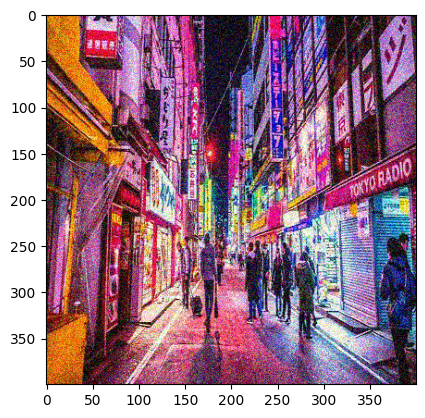

In [85]:
# Inicializa a imagem gerada como uma cópia da imagem de conteúdo convertida para float32
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

# Gera um tensor de ruído e o adiciona à imagem gerada
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)

# Recorta os valores dos pixels para ficarem no intervalo [0.0, 1.0]
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

# Imprime a forma da imagem gerada
print(generated_image.shape)

# Exibe a imagem gerada
plt.imshow(generated_image.numpy()[0])
plt.show()

**Explicação**:

1. **Definição da Função**:
   - `get_layer_outputs` é uma função que cria um novo modelo com base no modelo VGG existente.

2. **Obter Saídas das Camadas**:
   - A função percorre `layer_names`, uma lista contendo os nomes das camadas de interesse.
   - Para cada camada, `vgg.get_layer(layer[0]).output` é chamado para obter sua saída.

3. **Criar o Modelo**:
   - `tf.keras.Model` é usado para criar um novo modelo que recebe a mesma entrada que `vgg`, mas retorna as saídas das camadas listadas em `layer_names`.
   - O modelo original `vgg` serve como base, mas o novo modelo tem um conjunto personalizado de saídas.

4. **Retornar o Modelo**:
   - A função retorna o modelo Keras criado, que pode ser usado para calcular as ativações intermediárias desejadas.

In [86]:
def get_layer_outputs(vgg, layer_names):
    
    # Obter as saídas das camadas especificadas usando seus nomes
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    
    # Cria um modelo que tem a mesma entrada da VGG, mas retorna as saídas das camadas especificadas
    model = tf.keras.Model([vgg.input], outputs)
    return model


Definindo a camada de conteúdo e construindo o modelo.

In [87]:
# Define as camadas de estilo e de conteúdo
content_layer = [('block5_conv4', 1)]

# Obtém as saídas das camadas de estilo e de conteúdo
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Salvando as saídas das camadas de conteúdo e estilo em variáveis ​​separadas.

In [88]:
content_target = vgg_model_outputs(content_image)  
style_targets = vgg_model_outputs(style_image)     

1. **Converter e Inicializar a Imagem de Conteúdo**:
   - **`tf.image.convert_image_dtype(content_image, tf.float32)`**: Converte `content_image` para o tipo `tf.float32`, normalizando os valores dos pixels para o intervalo [0,0 - 1,0].
   - **`tf.Variable`**: Cria uma variável do TensorFlow a partir da imagem de conteúdo convertida. Isso é necessário para permitir que a imagem seja atualizável durante o processo de otimização.

2. **Obter Ativações da Imagem de Conteúdo**:
   - **`vgg_model_outputs`**: Passa `preprocessed_content` pelo modelo `vgg_model_outputs` para obter as ativações intermediárias das camadas de interesse.
   - `a_C` armazena as ativações dessas camadas para a imagem de conteúdo.

In [89]:
# Converte a imagem de conteúdo para o tipo float32 e cria uma variável TensorFlow
preprocessed_content = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

# Obtém as ativações das camadas para a imagem de conteúdo usando o modelo `vgg_model_outputs`
a_C = vgg_model_outputs(preprocessed_content)

O código abaixo define a_S como o tensor que fornece a ativação da camada oculta para `STYLE_LAYERS` usando nossa imagem de estilo.

In [90]:
# Converte a imagem de estilo para o tipo float32 e cria uma variável TensorFlow
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))

# Obtém as ativações das camadas para a imagem de estilo usando o modelo `vgg_model_outputs`
a_S = vgg_model_outputs(preprocessed_style)



**Explicação**:
- A função `clip_0_1` recebe uma imagem como tensor e garante que todos os valores dos pixels estejam entre 0.0 e 1.0.
- `tf.clip_by_value` é uma função do TensorFlow que recorta os valores dos elementos para ficarem dentro de um intervalo especificado (`clip_value_min` e `clip_value_max`).

- A função `tensor_to_image` converte um tensor TensorFlow para uma imagem do tipo PIL.
- **Como Funciona**:
  - O tensor é multiplicado por 255 para converter os valores dos pixels de [0, 1] para [0, 255].
  - O tensor é então convertido para um array NumPy com tipo `uint8` para representar corretamente os valores dos pixels.
  - A função verifica se o tensor tem mais de três dimensões (o que significaria que ele contém múltiplas imagens) e, se for o caso, apenas a primeira imagem é usada.
  - A imagem resultante é então criada usando `Image.fromarray`.


In [91]:
def clip_0_1(image):
    # Trunca todos os valores dos pixels no tensor `image` para ficarem entre 0 e 1
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    # Multiplica o tensor por 255 para converter para valores de pixels [0-255]
    tensor = tensor * 255
    
    # Converte o tensor em um array NumPy de tipo uint8
    tensor = np.array(tensor, dtype=np.uint8)
    
    # Verifica se o tensor tem mais de três dimensões e se a primeira dimensão é 1
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    
    # Retorna a imagem PIL criada a partir do array NumPy
    return Image.fromarray(tensor)

**Explicação**:

1. **Otimizador Adam**:
   - Um otimizador Adam é inicializado com uma taxa de aprendizado de 0,001 para otimizar a imagem gerada.

2. **`train_step`**:
   - A função `train_step` executa uma etapa de treinamento para otimizar a imagem gerada.
   - **`tf.GradientTape`**: Usado para gravar as operações e calcular os gradientes.
   - **Ativações da Imagem Gerada**: `a_G` contém as ativações das camadas de interesse para a imagem gerada.

3. **Cálculo de Custos**:
   - **Custo de Estilo (`J_style`)**: Calculado comparando `a_G` com `a_S`.
   - **Custo de Conteúdo (`J_content`)**: Calculado comparando `a_G` com `a_C`.
   - **Custo Total (`J`)**: Calculado como uma combinação ponderada dos custos de estilo e conteúdo.

4. **Aplicar Gradientes**:
   - Os gradientes são calculados em relação ao custo total e aplicados à imagem gerada usando o otimizador.
   - **`clip_0_1`**: Garante que os valores dos pixels estejam no intervalo [0.0 - 1.0].

5. **Retornar o Custo Total**:
   - A função retorna `J`, que é o custo total calculado para esta etapa de treinamento.


In [92]:
# Inicializa o otimizador Adam com uma taxa de aprendizado de 0,001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function()
def train_step(generated_image):
    # Usando tf.GradientTape para monitorar as operações para calcular gradientes
    with tf.GradientTape() as tape:
        # Calcula `a_G` como as saídas do `vgg_model_outputs` para a imagem gerada atual
        a_G = vgg_model_outputs(generated_image)
        
        # Calcula o custo de estilo
        J_style = compute_style_cost(a_S, a_G)

        # Calcula o custo de conteúdo
        J_content = compute_content_cost(a_C, a_G)

        # Calcula o custo total
        J = total_cost(J_content, J_style, alpha=10, beta=40)
        
    # Calcula o gradiente do custo em relação à imagem gerada
    grad = tape.gradient(J, generated_image)
    
    # Aplica os gradientes usando o otimizador
    optimizer.apply_gradients([(grad, generated_image)])
    
    # Trunca os valores dos pixels da imagem gerada para ficarem entre 0 e 1
    generated_image.assign(clip_0_1(generated_image))
    
    return J

In [93]:
# Inicializa a imagem gerada como uma cópia da imagem de conteúdo convertida para float32
generated_image = tf.Variable(generated_image)

Epoch 0: J_cost = 20719.2461


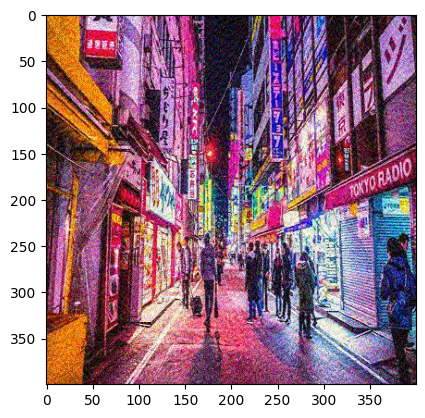

Epoch 1000: J_cost = 67.1732


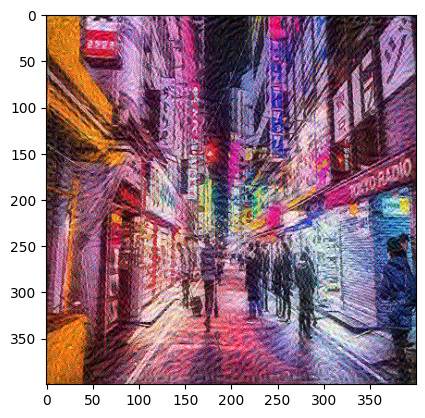

Epoch 2000: J_cost = 27.3430


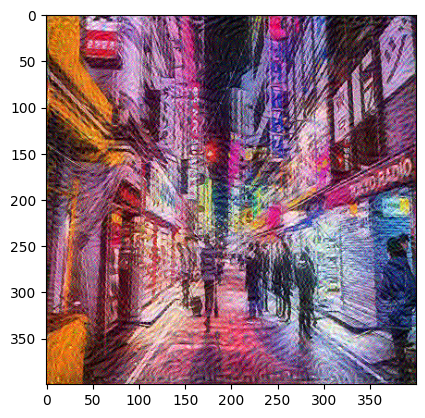

Epoch 3000: J_cost = 16.4673


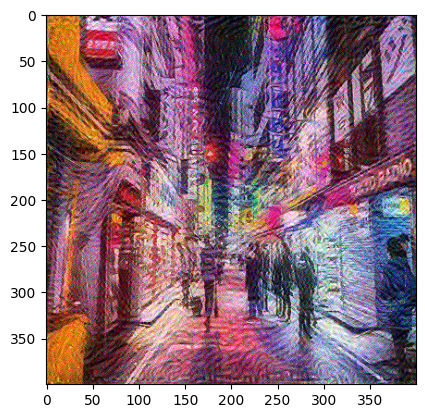

Epoch 4000: J_cost = 11.0805


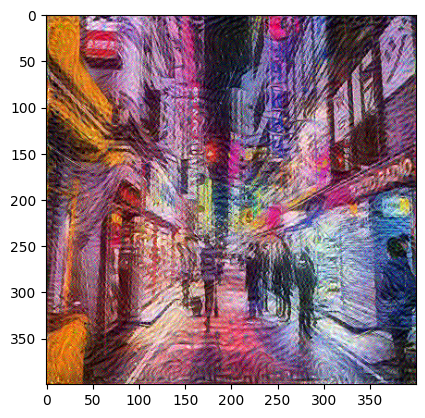

Epoch 5000: J_cost = 7.6970


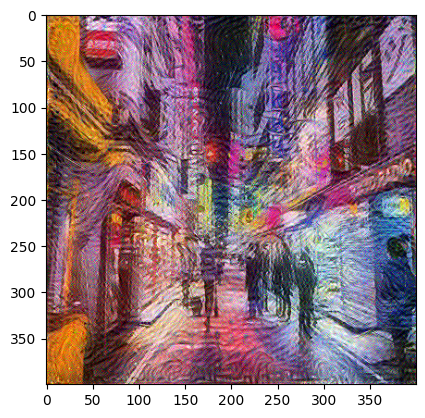

In [95]:
epochs = 5001
total_costs = []
for i in range(epochs):
    J = train_step(generated_image)
    total_costs.append(J.numpy())
    if i % 1000 == 0:
        print(f"Epoch {i}: J_cost = {J.numpy():.4f}")
        image = tensor_to_image(generated_image)
        imshow(image)
        
        plt.show() 

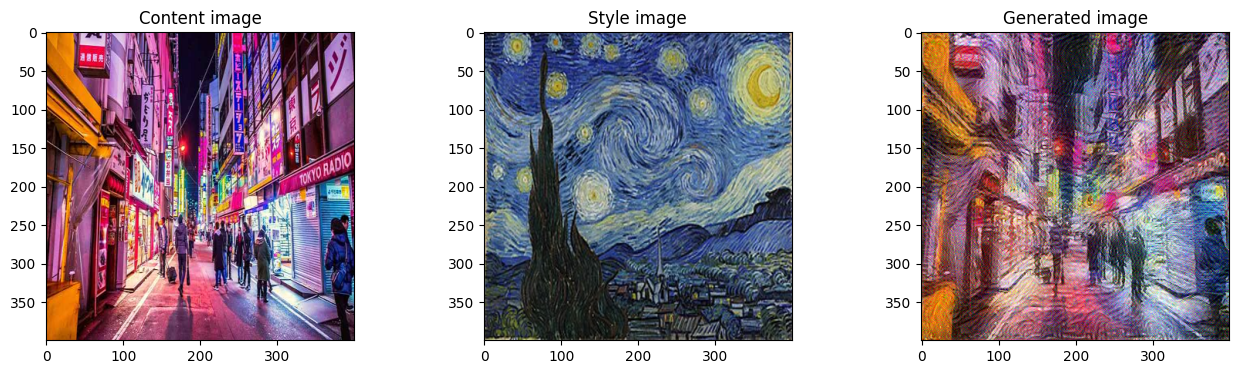

In [96]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

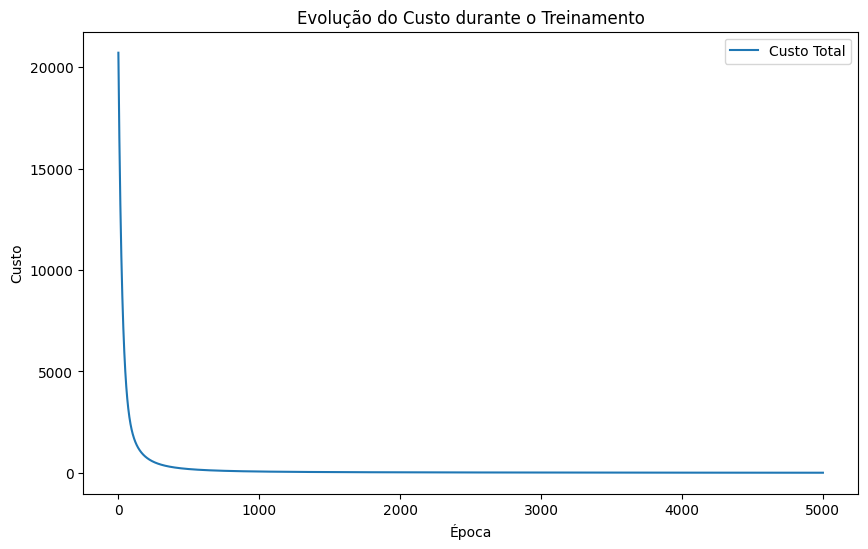

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(total_costs, label='Custo Total')
plt.xlabel('Época')
plt.ylabel('Custo')
plt.legend()
plt.title('Evolução do Custo durante o Treinamento')
plt.show()